In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

from catboost import CatBoostClassifier

PATH = 'D:\\DA\\RuCode\\Friends\\'

SEED = 42

# 1. Чтение и анализ данных

In [3]:
data_train = pd.read_csv(PATH + 'train_data.csv', index_col=0)
data_train.head()

,other_speaker,friend_response,Category
Id,,,
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР
1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",ЧЕНДЛЕР
2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",РОСС
3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",ДЖОУИ
4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",РОСС


In [4]:
data_val = pd.read_csv(PATH + 'val_data.csv', index_col=0)
data_val.head()

,other_speaker,friend_response,label
Id,,,
0,"Ладно, а мы вообще не обедаем?","Давай, пора стать серьезным, сбиться с толку. ...",МОНИКА
1,"Ладно, ладно, послушай, я знаю, что сегодня ве...","Ладно, вот и все! Слезь с нее!",РОСС
2,"Ага. Знаешь, у меня есть все эти чувства, и я ...","Хорошо, я видела довольно большого голубя.",ДЖОУИ
3,"Боже мой! один пару минут назад, а теперь я.","Постой, ты не можешь здесь рожать! То есть я н...",МОНИКА
4,"Не такой, как он сам по себе, просто не такой,...","Посмотрите, это художник, ранее известный как ...",РОСС


In [5]:
data_test = pd.read_csv(PATH + 'test.csv', index_col=0)
data_test.head()

,other_speaker,friend_response
Id,,
0,"Но я безработный, моя музыка - это все, что у ...",Меня застрелят. Любой совет?
1,Посмотри. Пятьсот семнадцать коробок!,"Боже мой, как ты это сделал?"
2,"Хорошо. Хорошо. Помогло бы, если бы я подошел ...",Это было бы очень полезно!
3,"Росс, чего ты так долго?","Простите, это как будто не для быстрого отдыха!"
4,Так кто ты?,"Ну, наши имена действительно Моника и Чендлер...."


In [6]:
data_train.shape, data_val.shape, data_test.shape

((24993, 3), (2778, 3), (3086, 2))

Объединим учебную и валидационную выборки:

In [7]:
data_all = pd.concat((data_train.rename(columns={'Category': 'label'}), data_val))
data_all.head()

,other_speaker,friend_response,label
Id,,,
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР
1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",ЧЕНДЛЕР
2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",РОСС
3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",ДЖОУИ
4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",РОСС


In [8]:
data_all.shape

(27771, 3)

Посмотрим на распределение классов в объединенной выборке:

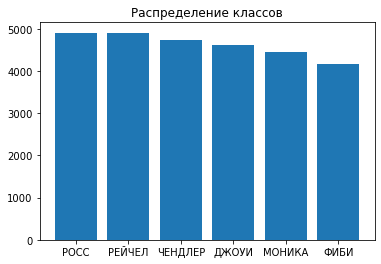

In [11]:
plt.bar(x=data_all['label'].value_counts().index, height=data_all['label'].value_counts().values);
plt.title('Распределение классов');

Сделаем Label Encoding для меток классов:

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_all['label'] = le.fit_transform(data_all['label'])

In [14]:
data_all.head()

,other_speaker,friend_response,label
Id,,,
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",5
1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",5
2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",3
3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",0
4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",3


# 2. Генерация новых признаков

Проверим, есть ли совпадающие реплики в other_speaker и friend_response, которые позволят нам определить автора реплики other_speaker:

In [23]:
friend_responses = set(data_all['friend_response'].unique())
other_speakers = set(data_all['other_speaker'].unique()).union(set(data_test['other_speaker'].unique()))

print('Количество пересечений:', len(friend_responses & other_speakers))

Количество пересечений: 10776


Т.е. в 10776 случаях нам точно известен автор реплики из колонки other_speaker. Добавим информацию об авторе реплики other_speaker в наш датасет:

In [24]:
data_resp = data_all[['friend_response', 'label']].copy()
data_resp.columns = ['other_speaker', 'other_speaker_label']
data_resp.head()

,other_speaker,other_speaker_label
Id,,
0,"Знаешь, я думаю, ты сможешь ее забрать.",5
1,"Эй, знаешь что, если ты собираешься это сделат...",5
2,"Как я уже сказал, я подумывал отвести Эмму в м...",3
3,"Эй, но хоть ты получил это крутое сияние берем...",0
4,"Ладно, послушайте, вчера я бы даже подумал пер...",3


In [25]:
data_all = data_all.merge(data_resp, on='other_speaker', how='left')
data_all['other_speaker_label'] = data_all['other_speaker_label'].fillna(-1).astype(int)

data_test = data_test.merge(data_resp, on='other_speaker', how='left')
data_test['other_speaker_label'] = data_test['other_speaker_label'].fillna(-1).astype(int)

In [26]:
data_all.head()

,other_speaker,friend_response,label,other_speaker_label
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",5,-1
1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",5,-1
2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",3,-1
3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",0,4
4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",3,2


In [27]:
data_test.head()

,other_speaker,friend_response,other_speaker_label
0,"Но я безработный, моя музыка - это все, что у ...",Меня застрелят. Любой совет?,4
1,Посмотри. Пятьсот семнадцать коробок!,"Боже мой, как ты это сделал?",-1
2,"Хорошо. Хорошо. Помогло бы, если бы я подошел ...",Это было бы очень полезно!,-1
3,"Росс, чего ты так долго?","Простите, это как будто не для быстрого отдыха!",2
4,Так кто ты?,"Ну, наши имена действительно Моника и Чендлер....",-1


In [28]:
data_all['other_speaker_label'].value_counts(dropna=False, normalize=True)

-1    0.648122
 5    0.069929
 1    0.061251
 2    0.059919
 3    0.058334
 0    0.055093
 4    0.047352
Name: other_speaker_label, dtype: float64

In [29]:
data_test['other_speaker_label'].value_counts(dropna=False, normalize=True)

-1    0.657485
 5    0.069669
 1    0.061568
 3    0.059624
 2    0.054115
 0    0.050875
 4    0.046662
Name: other_speaker_label, dtype: float64

Итак, теперь примерно в 35% случаев нам известен автор первой реплики.

# 3. Обработка текста

Произведем токенизацию и лемматизацию текста.

In [33]:
# Применение построенной далее модели показало, что если удалять из разговорных фраз стоп-слова, качество класификации падает

STOP_DICT_SIZE = 0

import string
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')[:STOP_DICT_SIZE]

In [34]:
# Токенизация: приведение к нижнему регистру, удаление знаков препинания, чисел

def clear_text(text):
    pre_str = "".join([ch if ch not in string.punctuation else '' for ch in str(text).lower()])
    pre_str = "".join([ch if not ch.isdigit() else ' ' for ch in pre_str])
    return " ".join([word for word in pre_str.split() if word not in stop_words and word != ' '])

In [36]:
from pymystem3 import Mystem

mystem = Mystem()

# Лемматизация с использованием библиотеки pymystem3

def lemmatize(text):
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in {' ', '\n'}]
    return " ".join(tokens)

In [37]:
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
stemmer = SnowballStemmer("russian")

# Лемматизация с использованием библиотеки nltk.stem.snowball

def lemmatize2(text):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in {' ', '\n'}]
    return " ".join(stemmed_tokens)

Посмотрим на оба варианта лемматизации:

In [38]:
text_0 = data_all['friend_response'].values[0]
print(text_0, '->', clear_text(text_0), '->', lemmatize(clear_text(text_0)))

Знаешь, я думаю, ты сможешь ее забрать. -> знаешь я думаю ты сможешь ее забрать -> знать я думать ты смочь она забирать


In [39]:
print(text_0, '->', clear_text(text_0), '->', lemmatize2(clear_text(text_0)))

Знаешь, я думаю, ты сможешь ее забрать. -> знаешь я думаю ты сможешь ее забрать -> знаеш я дума ты сможеш е забра


Оба варианта лемматизации работают неплохо, но вариант с nltk.stem.snowball - гораздо более быстрый. Будем использовать его.

In [40]:
data_all['response_clear'] = data_all['friend_response'].apply(clear_text)
data_test['response_clear'] = data_test['friend_response'].apply(clear_text)

data_all['speaker_clear'] = data_all['other_speaker'].apply(clear_text)
data_test['speaker_clear'] = data_test['other_speaker'].apply(clear_text)

In [44]:
lem_all = []
for text in tqdm_notebook(data_all['response_clear'].values):
    lem_all.append(lemmatize2(text))

In [45]:
lem_test = []
for text in tqdm_notebook(data_test['response_clear'].values):
    lem_test.append(lemmatize2(text))

In [46]:
data_all['response_lem'] = lem_all
data_test['response_lem'] = lem_test

In [47]:
lem_all = []
for text in tqdm_notebook(data_all['speaker_clear'].values):
    lem_all.append(lemmatize2(text))

In [48]:
lem_test = []
for text in tqdm_notebook(data_test['speaker_clear'].values):
    lem_test.append(lemmatize2(text))

In [49]:
data_all['speaker_lem'] = lem_all
data_test['speaker_lem'] = lem_test

In [50]:
data_all.head()

,other_speaker,friend_response,label,other_speaker_label,response_clear,speaker_clear,response_lem,speaker_lem
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",5,-1,знаешь я думаю ты сможешь ее забрать,хорошо все в порядке достаточно достаточно дос...,знаеш я дума ты сможеш е забра,хорош все в порядк достаточн достаточн достато...
1,"О, хочешь доброго имени, иди с Джоуи. Джои тво...","Эй, знаешь что, если ты собираешься это сделат...",5,-1,эй знаешь что если ты собираешься это сделать ...,о хочешь доброго имени иди с джоуи джои твой п...,э знаеш что есл ты собира эт сдела есл собира ...,о хочеш добр имен ид с джоу джо тво приятел дж...
2,"Боже мой, что!?","Как я уже сказал, я подумывал отвести Эмму в м...",3,-1,как я уже сказал я подумывал отвести эмму в му...,боже мой что,как я уж сказа я подумыва отвест эмм в муз нож...,бож мо что
3,Беременность тяжело сказывается на животе.,"Эй, но хоть ты получил это крутое сияние берем...",0,4,эй но хоть ты получил это крутое сияние береме...,беременность тяжело сказывается на животе,э но хот ты получ эт крут сиян беремен женщин,беремен тяжел сказыва на живот
4,"Ладно, нет, это неправильное решение. Это не т...","Ладно, послушайте, вчера я бы даже подумал пер...",3,2,ладно послушайте вчера я бы даже подумал перез...,ладно нет это неправильное решение это не так ...,ладн послуша вчер я бы даж подума перезвон е н...,ладн нет эт неправильн решен эт не так нет рос...


Посмотрим на зависимость целевой переменной от количества слов во фразе:

In [51]:
def get_words_count(text):
    pre_str = "".join([ch if ch not in string.punctuation else '' for ch in str(text).lower()])
    return len(pre_str.split())

In [52]:
data_all['words_count'] = data_all['friend_response'].apply(get_words_count)
data_test['words_count'] = data_test['friend_response'].apply(get_words_count)

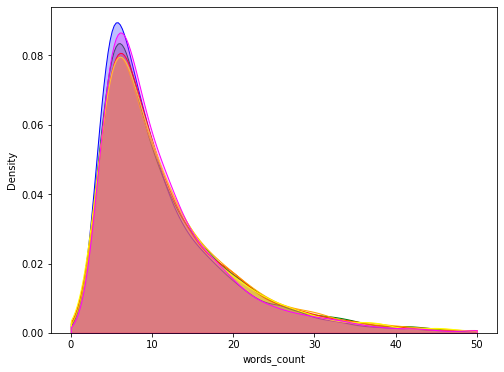

In [53]:
colors = ['green', 'blue', 'red', 'orange', 'yellow', 'magenta']
plt.figure(figsize = (8, 6))
for friend in range(len(le.classes_)):
    sns.kdeplot(data_all['words_count'][data_all['label'] == friend], color=colors[friend], clip=(0, 50), shade=True);

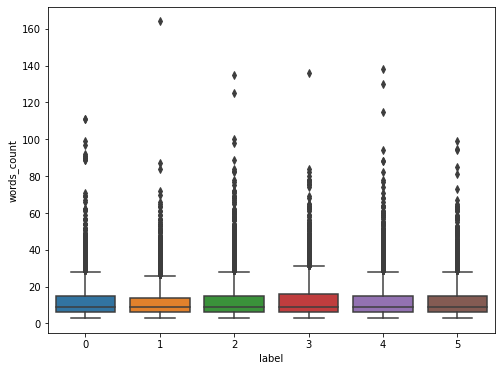

In [54]:
plt.figure(figsize = (8, 6))
sns.boxplot(x='label', y='words_count', data=data_all);

Видим, что некоторая зависимость прослеживается, хотя и не очень существенная.

# 4. Финальная модель

Будем использовать реализацию градиентного бустинга - CatBoostClassifier. Он хорошо работает с текстами "из коробки", не требуя предварительной обработки типа TfidfVectorizer:

In [55]:
X_col = ['speaker_lem', 'response_lem']
y_col = ['label']

ctb_df = data_all[X_col + y_col].copy()

In [56]:
train = ctb_df.sample(frac=0.8).copy()
val = ctb_df[~ctb_df.index.isin(train.index)].copy()

In [57]:
train.shape, val.shape

((22217, 3), (5554, 3))

In [58]:
ctb = CatBoostClassifier(depth=3, text_features=['speaker_lem', 'response_lem'], \
                        learning_rate=0.27, \
                        verbose=50, eval_metric='Accuracy', random_seed=SEED)

In [59]:
ctb.fit(train[X_col], train[y_col], \
        eval_set=(val[X_col], val[y_col]), plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2058334	test: 0.2057976	best: 0.2057976 (0)	total: 260ms	remaining: 4m 19s
50:	learn: 0.3055318	test: 0.3197695	best: 0.3199496 (48)	total: 6.87s	remaining: 2m 7s
100:	learn: 0.3174596	test: 0.3282319	best: 0.3287721 (97)	total: 13.5s	remaining: 2m
150:	learn: 0.3287122	test: 0.3285920	best: 0.3294923 (123)	total: 19.9s	remaining: 1m 51s
200:	learn: 0.3358239	test: 0.3296723	best: 0.3312928 (162)	total: 26.3s	remaining: 1m 44s
250:	learn: 0.3414502	test: 0.3300324	best: 0.3312928 (162)	total: 32.7s	remaining: 1m 37s
300:	learn: 0.3483819	test: 0.3269716	best: 0.3312928 (162)	total: 39.1s	remaining: 1m 30s
350:	learn: 0.3550884	test: 0.3280519	best: 0.3312928 (162)	total: 46.1s	remaining: 1m 25s
400:	learn: 0.3635054	test: 0.3280519	best: 0.3312928 (162)	total: 52.6s	remaining: 1m 18s
450:	learn: 0.3691768	test: 0.3275117	best: 0.3312928 (162)	total: 59.3s	remaining: 1m 12s
500:	learn: 0.3760184	test: 0.3282319	best: 0.3312928 (162)	total: 1m 5s	remaining: 1m 5s
550:	learn: 

In [50]:
del ctb

Обучим модель на всех данных, увеличив количество по сравнению с лучшей моделью на валидации, и сделаем предсказание:

In [60]:
ctb_final = CatBoostClassifier(depth=3, iterations=290, text_features=['speaker_lem', 'response_lem'], \
                               learning_rate=0.27, \
                               verbose=50, eval_metric='Accuracy', random_seed=SEED)

In [61]:
ctb_final.fit(ctb_df[X_col], ctb_df[y_col], plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2091390	total: 120ms	remaining: 34.6s
50:	learn: 0.3049224	total: 7.22s	remaining: 33.8s
100:	learn: 0.3171654	total: 14s	remaining: 26.3s
150:	learn: 0.3267437	total: 21s	remaining: 19.3s
200:	learn: 0.3344496	total: 27.9s	remaining: 12.3s
250:	learn: 0.3419394	total: 34.8s	remaining: 5.4s
289:	learn: 0.3468726	total: 40.4s	remaining: 0us


# 5. Используем информацию об авторе первой реплики

Скорректируем предсказанного героя, если он совпал с персонажем из other_speaker:

In [64]:
prediction = ctb_final.predict(data_test[X_col])
prediction_proba = ctb_final.predict_proba(data_test[X_col])
other_speaker = data_test['other_speaker_label']

In [65]:
n = 0
for ind in range(len(prediction)):
    if prediction[ind] == other_speaker[ind]:
        sec_proba = sorted(prediction_proba[ind], reverse=True)[1]
        prediction[ind] = np.where(prediction_proba[ind] == sec_proba)[0][0]
        n += 1
print('Скорректировано значений:', n)

Скорректировано значений: 169


In [66]:
data_test['Category'] = le.classes_[prediction]
data_test[['Category']].to_csv(PATH + 'submission_ctb_corrected.csv', sep=',', index_label='Id')
print("Your submission was successfully saved!")

Your submission was successfully saved!
